In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
fig, ax = plt.subplots(figsize=(8,8))
points, = ax.plot(np.random.rand(10), 'o')
ax.set_ylim(0, 1)
N = 100;
x  = np.random.uniform(low=0, high=1, size=(N,))
y  = np.random.uniform(low=0, high=1, size=(N,))
def update(i):
    ax.clear()
    for i in range(len(x)):
        x[i] += np.random.uniform(-0.1,0.1)
        y[i] += np.random.uniform(-0.1,0.1)

        if(x[i] > 1.0): x[i] = 1;
        if(y[i] > 1.0): y[i] = 1;
    ax.scatter(x, y)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
     # reformat things
    ax.set_xlabel('x')
    ax.set_ylabel('y')

ani = animation.FuncAnimation(fig, update, frames = 30, interval=100)
ani.save('animation.mp4',fps=30,dpi=200);

In [12]:
######### SETUP SOLUTION FIELD #############
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

A = 0.1;
eps = 0.25;
w = (2*np.pi)/10;

@nb.jit(parallel=True)
def f(x,t):
    a = eps *np.sin(w*t);
    b = 1 - 2*eps*np.sin(w*t);
    return a*(x**2) + b*x;

@nb.jit(parallel=True)
def f_x(x,t):
    a = eps *np.sin(w*t);
    b = 1 - 2*eps*np.sin(w*t);
    return 2*a*x + b;

@nb.jit(parallel=True)
def solution(x,y,t):
    funX    = f(x,t);

    u       = -np.pi * A *np.sin(np.pi*funX)*np.cos(np.pi*y);
    v       = np.pi*A*np.cos(np.pi*funX)*np.sin(np.pi*y)*f_x(x,t);

    return [u,v]


def WriteTextFile(filename,count,gridX,gridY,Sol_U,Sol_V):
    fileFinalName = filename + str(count).zfill(4) + ".txt"

    with open(fileFinalName,"w") as f:
        
        for x,y,u,v in zip(gridX.transpose().flatten(),gridY.transpose().flatten(),Sol_U.transpose().flatten(),Sol_V.transpose().flatten()):
            f.write("{:e}".format(x) + "\t" + "{:e}".format(y) + "\t" + "{:e}".format(u) + "\t" + "{:e}".format(v) + "\n"  );
            

    f.close();
    



In [13]:
##### Computational Parameters ##############
## TIME PARAMETERS ###
startTime = 0;
endTime = 20;
timestep = 0.05;
currentTime = startTime;


## SPACE PARAMETERS ###
h = 0.03;
xMax = 2;
xMin = 0;
yMax = 1;
yMin = 0;
xArray = np.arange(xMin,xMax+h,h)
yArray = np.arange(yMin,yMax+h,h)

gridX,gridY = np.meshgrid(xArray,yArray);


initialParticleX = gridX.copy();
initialParticleY = gridY.copy();

MainSolutionArray_u =[];
MainSolutionArray_v =[];
MainSolution_Magnitude = [];
#### Solution Array 

filename = "gyre"
count = 0


while (currentTime < endTime):
    sol_u = np.zeros((len(xArray),len(yArray)));
    sol_v = np.zeros((len(xArray),len(yArray)));
    temp = [];
    # fff = open(filename + str(count)  + ".dat", "a")
    # fff.write(str("X,Y,U,V,|U| \n "));
    current_u,current_v = solution(gridX,gridY,currentTime)
    MainSolutionArray_u.append(current_u)
    MainSolutionArray_v.append(current_v)
    MainSolution_Magnitude.append(np.sqrt(current_u**2 + current_v**2))
    count +=1;
    currentTime += timestep;
    WriteTextFile("data/Velocity",count,gridX,gridY,current_u,current_v)


In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import numpy as np

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random


plt.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[0]**2 + MainSolutionArray_u[1]**2 ),90,cmap="RdYlBu")
plt.streamplot(gridX,gridY,MainSolutionArray_u[0],MainSolutionArray_v[0],density = 0.65,integration_direction='both',color='black')

def update(i):
    global c, cf
    ax.clear()
    cf = ax.contourf(gridX,gridY,MainSolution_Magnitude[i],90,cmap="RdYlBu")
    ax.streamplot(gridX,gridY,MainSolutionArray_u[i],MainSolutionArray_v[i],density = 0.65,integration_direction='both',color='black')
    return ax,

fig, ax = plt.subplots(figsize=(8,4))
cf = ax.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[0]**2 + MainSolutionArray_v[0]**2 ), cmap='RdYlBu',alpha=0.5)
c = ax.contour(gridX,gridY,MainSolution_Magnitude[0], colors='k',alpha=0.4)
ani = animation.FuncAnimation(fig, update, frames = 100)
ani.save('gyre.mp4',fps=15,dpi=150);

In [39]:
@nb.jit(nopython=True, parallel=True)
def updateParticleDisplacement(Particle_X,timestep,InterpolatedVelocityValues_u):
    newPosition = Particle_X + timestep*(InterpolatedVelocityValues_u );
    return newPosition;

@nb.jit(nopython=True,parallel=True)
def updateFTLEScore(Particle_X,Particle_Y,Particle_FTLE,IntegrationTimeLength):
    global initialParticleX,initialParticleY
    for j in range( 1, Particle_X.shape[0] -1):
        for i in range(1, Particle_X.shape[1] -1):
            a11 = (Particle_X[i+1][j] - Particle_X[i-1][j] )/ (initialParticleX[i][j+1] - initialParticleX[i-1][j] )
            a12 = (Particle_X[i][j+1] - Particle_X[i][j-1] )/ (initialParticleY[i+1][j] - initialParticleY[i][j-1] )
            a21 = (Particle_Y[i][j+1] - Particle_Y[i][j-1] )/ (initialParticleX[i][j+1] - initialParticleX[i][j-1] )
            a22 = (Particle_Y[i+1][j] - Particle_Y[i-1][j] )/ (initialParticleY[i+1][j] - initialParticleY[i-1][j] )

            phi = np.array([[a11,a12],[a21,a22]]);
            Tensor = phi.transpose()@phi;

            Eigval = np.linalg.eigvals(Tensor);

            maxVal = np.max(Eigval);
            if(abs(maxVal) > 1e-6):
                FTLE_Val  = (1/(abs(IntegrationTimeLength))) * np.log(np.sqrt(maxVal));
            else:
                FTLE_Val = 0;

            Particle_FTLE[i][j] = FTLE_Val;
    return Particle_FTLE;


def FTLE_point(i, j,Particle_X,Particle_Y,IntegrationTimeLength):
    global initialParticleX,initialParticleY; 

    a11 =   (Particle_X[i][j+1] - Particle_X[i][j-1] )/ (initialParticleX[i][j+1] - initialParticleX[i][j-1] )
    a12 =   (Particle_X[i+1][j] - Particle_X[i-1][j] )/ (initialParticleY[i+1][j] - initialParticleY[i-1][j] )
    a21 =   (Particle_Y[i][j+1] - Particle_Y[i][j-1] )/ (initialParticleX[i][j+1] - initialParticleX[i][j-1] )
    a22 =   (Particle_Y[i+1][j] - Particle_Y[i-1][j] )/ (initialParticleY[i+1][j] - initialParticleY[i-1][j] )

    phi = np.array([[a11,a12],[a21,a22]]);
    Tensor = phi.transpose()@phi;

    Eigval = np.linalg.eigvals(Tensor);
    maxVal = np.max(Eigval);
    if(abs(maxVal) > 1e-6):
        FTLE_Val  = (1/(abs(IntegrationTimeLength))) * np.log(np.sqrt(maxVal));
    else:
        FTLE_Val = 0;
    
    return FTLE_Val;

def interpolateVelocityValues(Particle_Position_X,Particle_Position_Y,points,steps):
    global gridX,gridY , MainSolutionArray_u, MainSolutionArray_v;
    values = MainSolutionArray_u[steps].flatten();
    val_u =  griddata(points,values,(Particle_Position_X,Particle_Position_Y),fill_value=0,method="linear" );
    values = MainSolutionArray_v[steps].flatten();
    val_v =  griddata(points,values,(Particle_Position_X,Particle_Position_Y),fill_value=0,method="linear" );

    return [val_u,val_v];




def FTLETimeIntegration(currentTime,currentFrameIndex, FrameTimeStep, actualTimeStep , IntegrationTimeLength ,Particle_FTLE):
    

    global gridX,gridY,MainSolutionArray_u,MainSolutionArray_v;


    Particle_Position_X = initialParticleX.copy();
    Particle_Position_Y = initialParticleY.copy();
    particleOutsideDomain = np.zeros(Particle_Position_X.shape)
    particleComputeFTLE = np.ones(Particle_Position_X.shape)

    particleIntermediateFTLE = np.zeros(Particle_Position_X.shape);

    integrationTime = IntegrationTimeLength*actualTimeStep;

    points = np.array( (gridX.flatten(), gridY.flatten()) ).T

    steps = currentFrameIndex + FrameTimeStep;
    while ( steps < IntegrationTimeLength*FrameTimeStep + currentFrameIndex ):

        # Compute the interpolation of Velocity for given point 
        
        values = MainSolutionArray_v[steps].flatten();
        interpolated_velocityArray  = interpolateVelocityValues(Particle_Position_X,Particle_Position_Y,points,steps);
        
        interpolated_u =interpolated_velocityArray[0];
        interpolated_v =interpolated_velocityArray[1];

        ## obtain new displacement for particle to store temporarily 
        Particle_Position_X = updateParticleDisplacement(Particle_Position_X,actualTimeStep*FrameTimeStep,interpolated_u);
        Particle_Position_Y = updateParticleDisplacement(Particle_Position_Y,actualTimeStep*FrameTimeStep,interpolated_v);



        ### Check whether the particles have left the computational domain , in that case, compute the FTLE scores 
        ### and do not update further
        ### Logic is similar to the LCS Calculation.m tool in LCS matlab kit tool -- for Standardisation 
        ### this is just to deal with the particles which are about to leave the domain. 
        ### the FTLE values for those particles are computed in timesteps before it leaves the domain
        for i in range(Particle_Position_X.shape[0]):
            for j in range(Particle_Position_X.shape[1]):
                if( particleOutsideDomain[i][j] == 0):    ## particle is marked as inside the domain 

                    if((Particle_Position_X[i][j] - xMin)*(Particle_Position_X[i][j] - xMax) >=0  or  \
                         (Particle_Position_Y[i][j] - yMin)*(Particle_Position_Y[i][j] - yMax) >=0  ):
                        particleOutsideDomain[i][j] = 1;

                        ## update the FTLE in current time itself to avoid computing it at later time. 
                        if(particleComputeFTLE[i][j] == 1):
                            particleIntermediateFTLE[i][j] = FTLE_point(i, j,Particle_Position_X,Particle_Position_Y,integrationTime);
                            particleComputeFTLE[i][j] = 0;


                            ### Compute the FTLE for adjacent points also 
                            if(i > 0 and particleComputeFTLE[i-1][j] == 1):
                                particleIntermediateFTLE[i-1][j] = FTLE_point(i-1, j,Particle_Position_X,Particle_Position_Y,integrationTime);
                                particleComputeFTLE[i-1][j] == 0;
                            
                            if(j > 0 and particleComputeFTLE[i][j-1] == 1):
                                particleIntermediateFTLE[i][j-1] = FTLE_point(i, j-1,Particle_Position_X,Particle_Position_Y,integrationTime);
                                particleComputeFTLE[i][j-1] == 0;
                            
                            if(j < Particle_Position_X.shape[1] and particleComputeFTLE[i][j+1] == 1):
                                particleIntermediateFTLE[i][j+1] = FTLE_point(i, j+1,Particle_Position_X,Particle_Position_Y,integrationTime);
                                particleComputeFTLE[i][j+1] == 0;

                            if(i < Particle_Position_X.shape[0] and particleComputeFTLE[i+1][j] == 1):
                                particleIntermediateFTLE[i+1][j] = FTLE_point(i+1, j,Particle_Position_X,Particle_Position_Y,integrationTime);
                                particleComputeFTLE[i+1][j] == 0;
                        
                            pass;  ## If particleComputeFTLE[i][j] == 1
                    
                        pass; ## particle inside domain 


    steps += FrameTimeStep;

    ### Compute FTLE Fields for entire domain 
    Particle_FTLE= updateFTLEScore(Particle_Position_X,Particle_Position_Y,Particle_FTLE,IntegrationTimeLength)

    ## Replace the values which were stoped inbetween since the particle left the domain. 
    for i in range(Particle_Position_X.shape[0]):
        for j in range(Particle_Position_X.shape[1]):
            if(particleComputeFTLE[i][j] == 0):
                Particle_FTLE[i][j] = particleIntermediateFTLE[i][j];

        

    return Particle_FTLE


Done 0


IndexError: index 35 is out of bounds for axis 0 with size 35

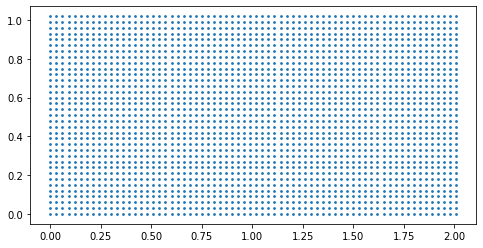

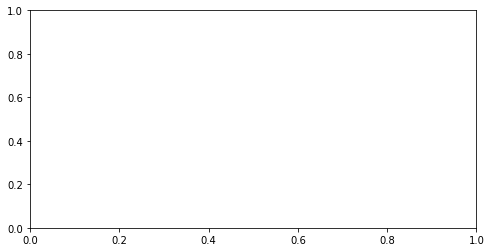

In [40]:
from scipy.interpolate import griddata
from celluloid import Camera

#### function for INITIALISING PARTICLES IN THE DOMAIN 
## Initialise particles at every grid point 

Particle_X = initialParticleX.copy();
Particle_Y = initialParticleY.copy();

Particle_ColorArray = np.empty(Particle_X.shape,dtype=object)

particleOutsideDomain = np.zeros(Particle_X.shape);   ## To keep track of whether the particle left the domain or not. 
particleComputeFTLE   = np.zeros(Particle_X.shape);   ## To keep track of whether the particle left the domain or not. 


## Display the Particle Grid in Initial Position 
fig, ax = plt.subplots(figsize=(8,4))
# cf = ax.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[0]**2 + MainSolutionArray_v[0]**2 ), cmap='RdYlBu',alpha=0.5)
particle = ax.scatter(Particle_X,Particle_Y,3)

##Array for storing the FTLE Arrays in entire domain 
Particle_FTLE_Array = [];

### Advect the particles forward in time 
## Use trapezoidal Rule to obtain the Integration Value


FlattenGrid  = np.array( (gridX.flatten(), gridY.flatten()) ).T

fig, ax = plt.subplots(figsize=(8,4))
camera = Camera(fig)


for i in range(2):
    print("Done" , i)
    
    pointVel_u = MainSolutionArray_u[i].flatten();
    pointVel_v = MainSolutionArray_v[i].flatten();
    pointVel_u_next = MainSolutionArray_u[i+1].flatten();
    pointVel_v_next = MainSolutionArray_v[i+1].flatten();

    ## Time Integration Loop for Computing FTLE for Current Frame 
    currentTime = i*timestep;
    FrameTimeStep = 1;
    IntegrationTimeLength = 15;
    Particle_FTLE = np.zeros(Particle_X.shape)

    FTLE = FTLETimeIntegration(currentTime,i, FrameTimeStep, timestep , IntegrationTimeLength ,Particle_FTLE);
    Particle_FTLE_Array.append(FTLE);
    
    # print("FTLE scre" , i)
    ## Apply color based on the maximum Range of the 
    maxFTLE  =  np.max(Particle_FTLE);
    colorArray = [['#C5C5C5' for x in range(len(Particle_FTLE[0]))] for y in range(len(Particle_FTLE))]
    colorArray =  np.array(colorArray)
    for i in range(len(Particle_FTLE)):
        for j in range(len(Particle_FTLE[0])):
            if(Particle_FTLE[i][j] > 0.5*maxFTLE):
                colorArray[i][j] = '#FF2D00';
            elif (Particle_FTLE[i][j] > 0.25*maxFTLE):
                colorArray[i][j] = '#03BB00';
            else:
                colorArray[i][j] = '#C5C5C5'
    # print("Color" , i)
    ax.scatter(Particle_X.flatten(),Particle_Y.flatten(),color=colorArray.flatten(),s=5);
    ax.set_facecolor('black')
    ax.set_xlim([0,2])
    ax.set_ylim([0,1])
    camera.snap();
    plt.show();

animation = camera.animate()
animation.save('FTLE.mp4') 
print("Figure Saved ")

In [7]:
np.max(Particle_FTLE)



0.0

51.562955047328906
26.834511459432505


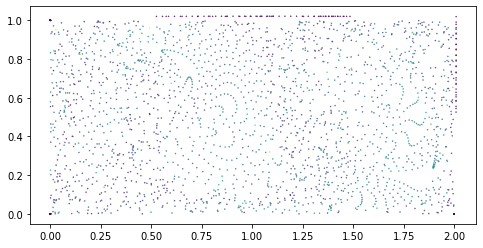

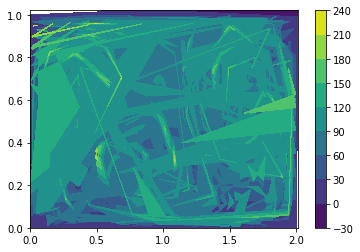

In [42]:
## Display the Particle Grid in Initial Position 
fig, ax = plt.subplots(figsize=(8,4))
# cf = ax.contourf(gridX,gridY,np.sqrt(MainSolutionArray_u[0]**2 + MainSolutionArray_v[0]**2 ), cmap='RdYlBu',alpha=0.5)
particle = ax.scatter(Particle_X,Particle_Y,c=Particle_FTLE,s=0.2)
print(np.linalg.norm(Particle_X,2))
print(np.linalg.norm(Particle_Y,2))
plt.show();


plt.contourf(Particle_X,Particle_Y,Particle_FTLE)
plt.colorbar()

In [69]:
## Write to Tecplot file 
Headers = ["x","y" , "FLTE"]
def writeToTecplotFile(Headers,xPos,yPos,val,fileName,count):
    readMode = 'a'
    if(count):
        fileFinalName = fileName + "_" + str(count) +"_" + ".dat";
        readMode = 'a'
    else:
        fileFinalName = fileName + ".dat";
        readMode = 'w'

    


    with open(fileFinalName,readMode) as f:
        if(count):
            f.write("TITLE : FTLE")
        
        l ='VARIABLES = ';
        for k in Headers:
            l += '"' + k + '",';

        f.write(l[:-1] + "\n");

        l = """Zone T = psi I = """  + str("{:e}".format(xPos.shape[0])) +  """ J = """ + str("{:e}".format(xPos.shape[1]));
        f.write(l+ "\n")

        l = """StrandID =1, SolutionTime = """ + str(count);
        f.write(l+ "\n");

        xPos = xPos.flatten();
        yPos = yPos.flatten();
        val = val.flatten();

        for x,y,val in zip(xPos,yPos,val):
            f.write( "{:e}".format(x) + "\t" + "{:e}".format(y) + "\t"  + "{:e}".format(val) + "\n")
        



writeToTecplotFile(Headers,Particle_X,Particle_Y,Particle_FTLE,"test",0)


In [71]:
Solx= np.arange(1,16).reshape((5,3))
Soly= np.arange(2,17).reshape((5,3))
from scipy.interpolate import griddata

X = np.arange(0,2+0.5,0.5);
Y = np.arange(0,1+0.5,0.5);

xx,yy = np.meshgrid(X,Y)

points = np.array( (xx.flatten(), yy.flatten()) ).T
# print(points)
values =  Solx.flatten()
# print(values)
Z0 = griddata( points, values, (xx,yy) )
print(Z0)

[[ 1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10.]
 [11. 12. 13. 14. 15.]]


In [48]:
Headers = ["x","y" , "FLTE"]
",".join((""" "  """,Headers,""" "  """))

TypeError: sequence item 1: expected str instance, list found

In [51]:
l = "VARIABLES = "
l[:-1]

'VARIABLES ='

In [63]:
a = ["apple","Bannana"]
b = ["Sucks","yummy"]

for i,j in zip(a,b):
    print(i,",",j)

apple , Sucks
Bannana , yummy
